# Loading Data

In [35]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools
import statsmodels.api as sm
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# I load the date set and fix the problem with missing Salaries for 59 players.
Hitter = pd.read_csv(r'C:\Users\panda\DecisionSupportSystems\Hitters.csv',index_col=0).dropna()
Hitter.index.name = 'Player'
Hitter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
AtBat        263 non-null int64
Hits         263 non-null int64
HmRun        263 non-null int64
Runs         263 non-null int64
RBI          263 non-null int64
Walks        263 non-null int64
Years        263 non-null int64
CAtBat       263 non-null int64
CHits        263 non-null int64
CHmRun       263 non-null int64
CRuns        263 non-null int64
CRBI         263 non-null int64
CWalks       263 non-null int64
League       263 non-null object
Division     263 non-null object
PutOuts      263 non-null int64
Assists      263 non-null int64
Errors       263 non-null int64
Salary       263 non-null float64
NewLeague    263 non-null object
dtypes: float64(1), int64(16), object(3)
memory usage: 43.1+ KB


In [2]:
# Checking the all players have a value at the column Salary
print("Number of null values:", Hitter["Salary"].isnull().sum())


Number of null values: 0


In [3]:
# Cleaning predictors up using Panda by genereting dummy variables, separate out the responses variable, and putting everything back together.
Hitter_dimmies = pd.get_dummies(Hitter[['League', 'Division', 'NewLeague']])

In [14]:
y = Hitter.Salary

# Drop the independent variable (Salary)
X_ = Hitter.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64')
# Define the feature set X.
X = pd.concat([X_, Hitter_dimmies[['League_N', 'Division_W', 'NewLeague_N']]], axis=1)
data=y;

In [15]:
# we use the  training observations. If the full data set is used to perform the best subset selection step, the validation set errors and cross-validation errors that we obtain will not be accurate estimates of the test error.

## Model selection using validation set approach

In [27]:
np.random.seed(seed=12)
train = np.random.choice([True, False], size = len(data), replace = True)
test = np.invert(train)

In [36]:
def subsetProcess(f_set, X_train, y_train, X_test, y_test):
    # Cal Rss and fitting the model
    cur_model = sm.OLS(y_train,X_train[list(f_set)])
    regr = cur_model.fit()
    RSS = ((regr.predict(X_test[list(f_set)]) - y_test) ** 2).sum()
    return {"model":regr, "RSS":RSS}

In [37]:
def forward_subset(predictors, X_train, y_train, X_test, y_test):
    
    cur_results = []

    # Pull out predictors that are missing processing
    remaining_predictors = [t for t in X_train.columns if t not in predictors]
    
    for t in remaining_predictors:
        cur_results.append(subsetProcess(predictors+[t], X_train, y_train, X_test, y_test))
    
    # wrap using DataFrame
    all_models = pd.DataFrame(cur_results)
    
    # Selecting best model based on RSS
    best_RSS_model = all_models.loc[all_models['RSS'].argmin()]
        
    # Return the best model
    return best_RSS_model

In [38]:
train_models = pd.DataFrame(columns=["RSS", "model"])

predictors = []

for i in range(1,len(X.columns)+1):    
    train_models.loc[i] = forward_subset(predictors, X[train], y[train], X[test], y[test])
    predictors = train_models.loc[i]["model"].model.exog_names

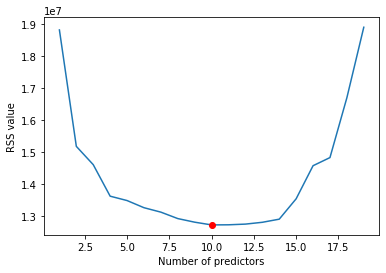

In [39]:
plt.plot(train_models["RSS"])
plt.xlabel('Number of predictors')
plt.ylabel('RSS value')
plt.plot(train_models["RSS"].argmin(), train_models["RSS"].min(), "or")

In [40]:
test_models = pd.DataFrame(columns=["RSS", "model"])

predictors = []

for i in range(1,11):    
    test_models.loc[i] = forward_subset(predictors, X[test], y[test], X[test], y[test])
    predictors = test_models.loc[i]["model"].model.exog_names

In [45]:
print(train_models.loc[10, "model"].model.exog_names)
print(test_models.loc[10, "model"].model.exog_names)

['Walks', 'CRBI', 'Hits', 'Division_W', 'CWalks', 'CRuns', 'AtBat', 'League_N', 'CHits', 'Runs']
['Walks', 'CRBI', 'Assists', 'Division_W', 'CWalks', 'CRuns', 'PutOuts', 'Errors', 'League_N', 'CHmRun']


## Cross-Validation

In [55]:
t = 10        # Taking 10 fold of numbers 
np.random.seed(seed=1)
folds = np.random.choice(t, size = len(y), replace = True)

# Create Errors for storing values. 
errors_cv = pd.DataFrame(columns=range(1,t+1), index=range(1,20))
crossval_errors = errors_cv.fillna(0)

In [56]:
crossV_models = pd.DataFrame(columns=["RSS", "model"])
    
# Loop iteration over folds
for j in range(1,k+1):

    
    predictors = []
    
   
    for i in range(1,len(X.columns)+1):    
    
     
        crossV_models.loc[i] = forward_subset(predictors, X[folds != (j-1)], y[folds != (j-1)], X[folds == (j-1)], y[folds == (j-1)])
        
        # Cross-validation error is stored
        crossval_errors[j][i] = crossV_models.loc[i]["RSS"]

        # Predictors is taken out
        predictors = crossV_models.loc[i]["model"].model.exog_names

In [57]:
crossval_errors

,1,2,3,4,5,6,7,8,9,10
1,3107900,3212304,4840103,2475453,3750302,1551976,1827366,9115194,1370720,2204862
2,2354036,2247881,3414444,1642455,3160950,1250564,1567469,8520751,1081052,1856304
3,2148733,2012864,3009435,1566581,2775618,907304,1260460,8456576,969784,1674333
4,1946031,1870511,2630784,1521525,2618750,805135,1143882,8331746,857553,1618265
5,1850398,1605148,2537690,1502728,2608466,776171,1124174,8221957,793919,1574253
6,1778324,1574266,2498621,1482575,2632055,776163,1115741,8196969,781235,1534220
7,1761111,1524413,2452303,1480345,2661104,779716,1104388,8171959,776457,1503831
8,1733230,1529625,2418943,1477510,2660654,803859,1100753,7449396,774589,1536790
9,1773705,1607919,2381843,1504519,2677002,821629,1096925,7136283,774616,1542746
10,1865909,1682293,2378624,1528102,2597881,854997,1136162,7059485,775993,1597314


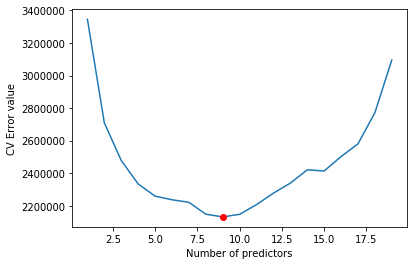

In [58]:
cv_mean = crossval_errors.apply(np.mean, axis=1)

plt.plot(cv_mean)
plt.xlabel('Number of predictors')
plt.ylabel('CV Error value')
plt.plot(cv_mean.argmin(), cv_mean.min(), "or")

In [59]:
print(crossV_models.loc[9, "model"].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.685
Model:                            OLS   Adj. R-squared (uncentered):              0.672
Method:                 Least Squares   F-statistic:                              54.56
Date:                Mon, 20 Apr 2020   Prob (F-statistic):                    8.32e-52
Time:                        18:54:18   Log-Likelihood:                         -1737.9
No. Observations:                 235   AIC:                                      3494.
Df Residuals:                     226   BIC:                                      3525.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------